In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from mne import read_epochs
from hmpai.data import StageFinder, SAT_CLASSES_ACCURACY, SAT_CLASSES_SPEED, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "sat2/preprocessed_500hz/S1_epo.fif"
# info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)

epoch = read_epochs(info_path)
epoch.set_montage('biosemi64')
positions = epoch.info

Reading /workspace/data_local/sat2/preprocessed_500hz/S1_epo.fif ...
    Found the data of interest:
        t =    -300.00 ...    4000.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
2376 matching events found
No baseline correction applied
0 projection items activated


#### New version (high force)

In [3]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz_long.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    # fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 1},
    # fit_args={"step": 1, "by_sample": True},
    # fit_args={"by_sample": True},
    # fit_args={"step": 5},
    # fit_args={"diagnostic": True},
    verbose=False,
    condition_variable="condition",
    condition_method="equal",
    extra_split=[("force", "equal", "high")],
    fits_to_load=["250hz_accuracy_high.nc", "250hz_speed_high.nc"],
    n_comp=10,
    event_width=25,
)
# Retraining model with smaller window
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Loading fitted HMP model for accuracy condition
Loading fitted HMP model for speed condition


In [4]:
from hmpai.behaviour.sat2 import *
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
stage_finder.epoch_data_offset = merge_data_xr(stage_finder.epoch_data_offset, behaviour_sat2)

In [5]:
stage_finder.epoch_data_offset_right = stage_finder.epoch_data_offset.where(stage_finder.epoch_data_offset['givenResp'] == 'right', drop=True)
stage_finder.epoch_data_offset_left = stage_finder.epoch_data_offset.where(stage_finder.epoch_data_offset['givenResp'] == 'left', drop=True)

(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

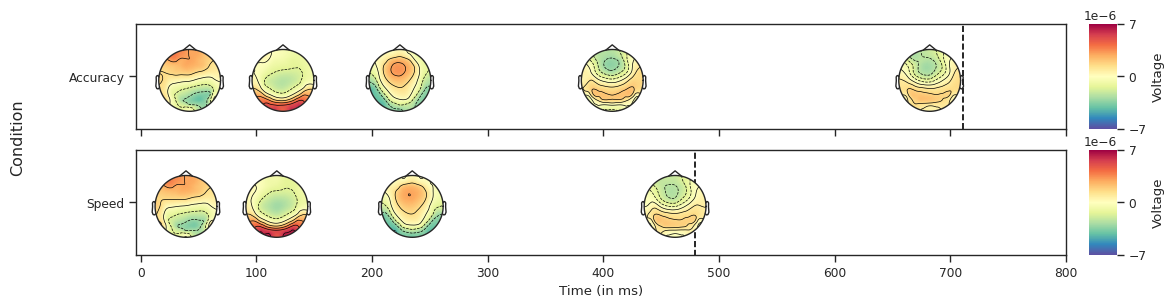

In [13]:
stage_finder.epoch_data_offset = stage_finder.epoch_data_offset_right
stage_finder.visualize_model(positions, max_time=800)


(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

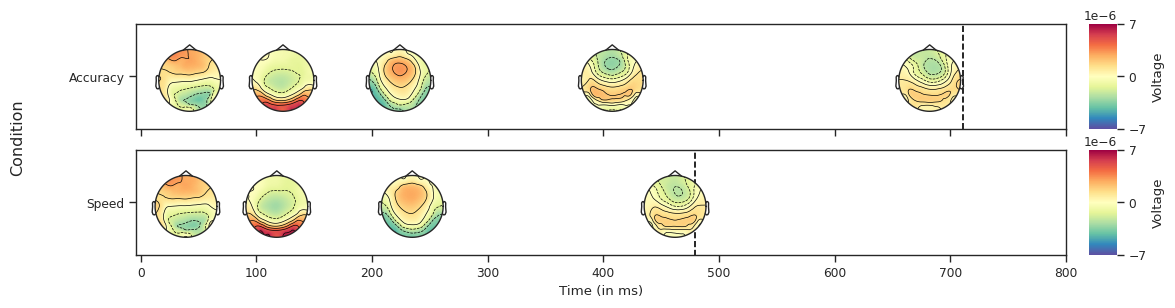

In [14]:
stage_finder.epoch_data_offset = stage_finder.epoch_data_offset_left
stage_finder.visualize_model(positions, max_time=800) 

In [ ]:
stage_finder.models[0]

In [6]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_high.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_high.nc")

250hz_accuracy_high.nc saved
250hz_speed_high.nc saved


In [4]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_high.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing particip

In [5]:
stage_data.to_netcdf(output_path)

#### New version (low force)

In [3]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz_long.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    # fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 1},
    # fit_args={"step": 1, "by_sample": True},
    # fit_args={"by_sample": True},
    # fit_args={"step": 5},
    verbose=False,
    condition_variable="condition",
    condition_method="equal",
    extra_split=[("force", "equal", "low")],
    fits_to_load=["250hz_accuracy_low.nc", "250hz_speed_low.nc"],
    n_comp=10,
    event_width=25,
)
# Retraining model with smaller window
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Loading fitted HMP model for accuracy condition
Loading fitted HMP model for speed condition


In [4]:
from hmpai.behaviour.sat2 import *
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
stage_finder.epoch_data_offset = merge_data_xr(stage_finder.epoch_data_offset, behaviour_sat2)

In [5]:
stage_finder.epoch_data_offset_right = stage_finder.epoch_data_offset.where(stage_finder.epoch_data_offset['givenResp'] == 'right', drop=True)
stage_finder.epoch_data_offset_left = stage_finder.epoch_data_offset.where(stage_finder.epoch_data_offset['givenResp'] == 'left', drop=True)

(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

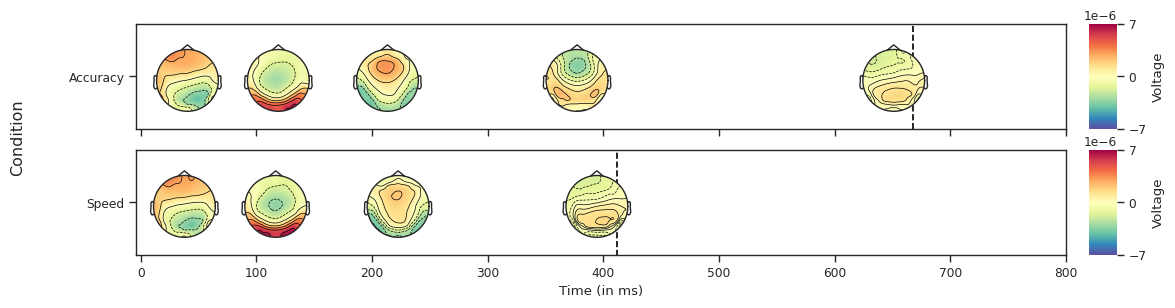

In [6]:
stage_finder.epoch_data_offset = stage_finder.epoch_data_offset_right
stage_finder.visualize_model(positions, max_time=800)


(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

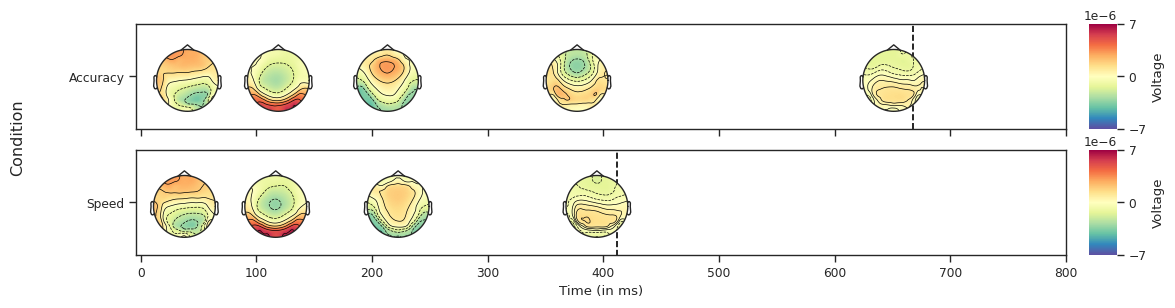

In [7]:
stage_finder.epoch_data_offset = stage_finder.epoch_data_offset_left
stage_finder.visualize_model(positions, max_time=800) 

(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

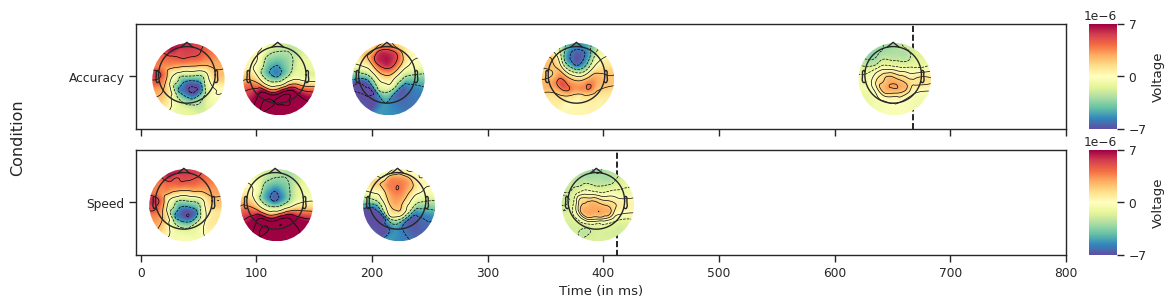

In [4]:
stage_finder.visualize_model(positions, max_time=800)


In [5]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_low.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_low.nc")

250hz_accuracy_low.nc saved
250hz_speed_low.nc saved


In [7]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_low.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S14
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing particip

In [8]:
stage_data.to_netcdf(output_path)

#### Testing

In [ ]:
cpus = 12

epoched_data_path = DATA_PATH / "sat2/data_250hz_small.nc"
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_small.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    # fit_args={"step": 1, "by_sample": True},
    # fit_args={"by_sample": True},
    fit_args={"step": 5},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    # fits_to_load=["250hz_accuracy.nc", "250hz_speed.nc"],
    n_comp=10,
    event_width=50,
)
# Retraining model with smaller window
stage_finder.fit_model()


(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

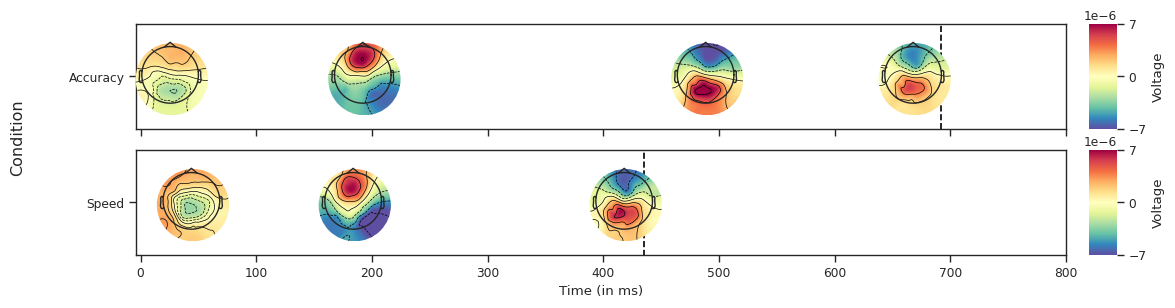

In [8]:
stage_finder.visualize_model(positions, max_time=800)


##### Results:
- 0 cpus, stopped after a while. 2268 MiB
- 12 cpus with load_dataset,
- 12 cpus with open_dataset, 

In [3]:
%load_ext memory_profiler

In [3]:
%mprun -f hmp.models.hmp.fit_single stage_finder.fit_model()

UsageError: Line magic function `%mprun` not found.


(<Figure size 1200x300 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (in ms)'>], dtype=object))

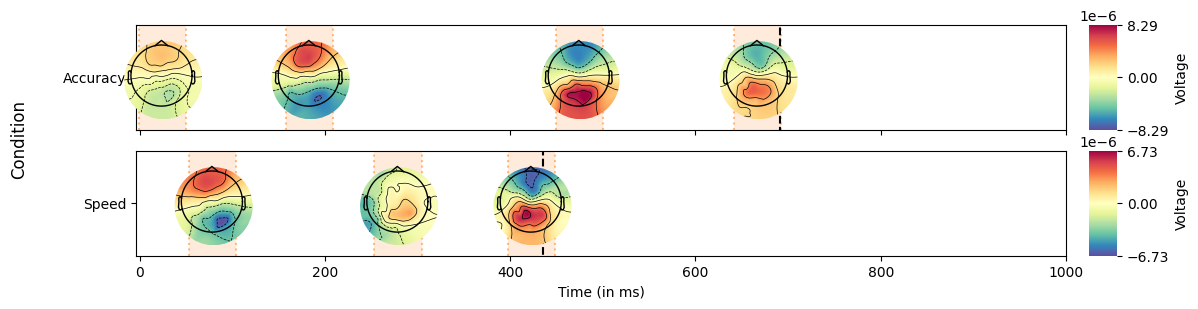

In [17]:
stage_finder.visualize_model(positions, max_time=8000)

In [ ]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed.nc")

In [ ]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

In [ ]:
stage_data.to_netcdf(output_path)

#### ALL Participants

In [3]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz_low_old.nc"
output_path = DATA_PATH / "sat2/stage_data_proba_250hz.nc"
# epoched_data_path = DATA_PATH / "sat2/data_250hz_filtered.nc"
# output_path = DATA_PATH / "sat2/stage_data_proba_250hz_filtered.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

# DO 10 COMPS
# stage_finder = StageFinder(
#     epoched_data_path,
#     labels,
#     conditions=conditions,
#     cpus=cpus,
#     fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
#     fit_args={"starting_points": 1},
#     verbose=False,
#     condition_variable="event_name",
#     condition_method="contains",
#     # fits_to_load=["250hz_accuracy.nc", "250hz_speed.nc"],
#     n_comp=10,
#     event_width=40,
# )
stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit",  # n_events is extracted from the amount of labels in 'conditions' variable
    # fit_args={"step": 1, "by_sample": True},
    # fit_args={"by_sample": True},
    # fit_args={"step": 5},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    fits_to_load=["250hz_accuracy_new_25ms.nc", "250hz_speed_new_25ms.nc"],
    n_comp=10,
    event_width=25,
)
# Retraining model with smaller window
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Fitting HMP model for accuracy condition


  0%|          | 0/168 [00:00<?, ?it/s]

Transition event 1 found around sample 25
Transition event 2 found around sample 46
Transition event 3 found around sample 66
Transition event 4 found around sample 98
Transition event 5 found around sample 153

All events found, refitting final combination.
Estimating 5 events model
parameters estimated for 5 events model
Fitting HMP model for speed condition


  0%|          | 0/104 [00:00<?, ?it/s]

Transition event 1 found around sample 18
Transition event 2 found around sample 35
Transition event 3 found around sample 81
Transition event 4 found around sample 95

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


In [ ]:
fig, ax = stage_finder.visualize_model(positions, max_time=800)
fig.tight_layout()

In [11]:
fig.savefig('../../img/hmp_fit_step5_50ms.svg', transparent=True)

In [4]:
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_new_25ms.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_new_25ms.nc")

250hz_accuracy_new_25ms.nc saved
250hz_speed_new_25ms.nc saved


In [11]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)
# CHANGE OUTPUT PATH AND SAVE WITH DIFF NAME

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participan

In [13]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_step5_50_split.nc"
stage_data.to_netcdf(output_path)

#### SUBSETS

Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


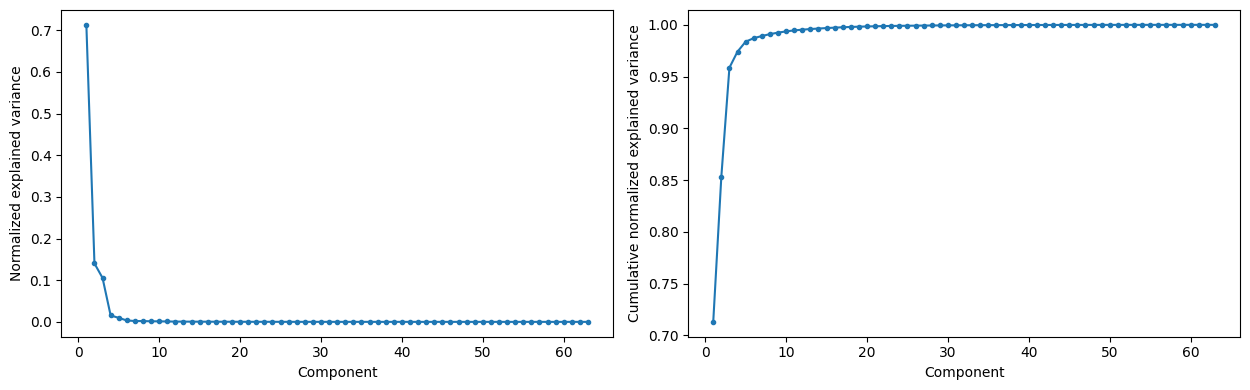

Loading fitted HMP model for accuracy condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3165: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Loading fitted HMP model for speed condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3165: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


In [18]:
cpus = 10

epoched_data_path = DATA_PATH / "sat2/data_250hz_part1.nc"
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

# 5 comps
stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    fits_to_load=["250hz_accuracy_part1.nc", "250hz_speed_part1.nc"]
)
# Retraining model with smaller window
stage_finder.fit_model()

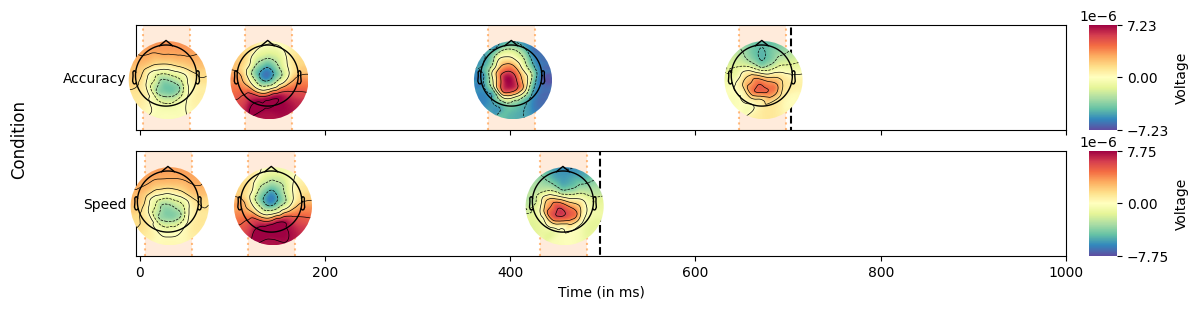

In [19]:
import matplotlib.pyplot as plt
fig, ax = stage_finder.visualize_model(positions, max_time=1000)

In [44]:
fig.tight_layout()
fig.savefig('../../img/hmp_fit.svg', transparent=True)

In [4]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_part1.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_part1.nc")

250hz_accuracy_part2.nc saved
250hz_speed_part2.nc saved


In [ ]:
output_path = DATA_PATH / "sat2/stage_data_250hz_part1.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_bump_to_bump__)

In [4]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18


In [5]:
stage_data.to_netcdf(output_path)

In [4]:
data = xr.load_dataset(epoched_data_path)

In [5]:
data.samples

<xarray.DataArray 'samples' (samples: 698)> Size: 6kB
array([  0,   1,   2, ..., 695, 696, 697])
Coordinates:
  * samples  (samples) int64 6kB 0 1 2 3 4 5 6 7 ... 691 692 693 694 695 696 697

Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


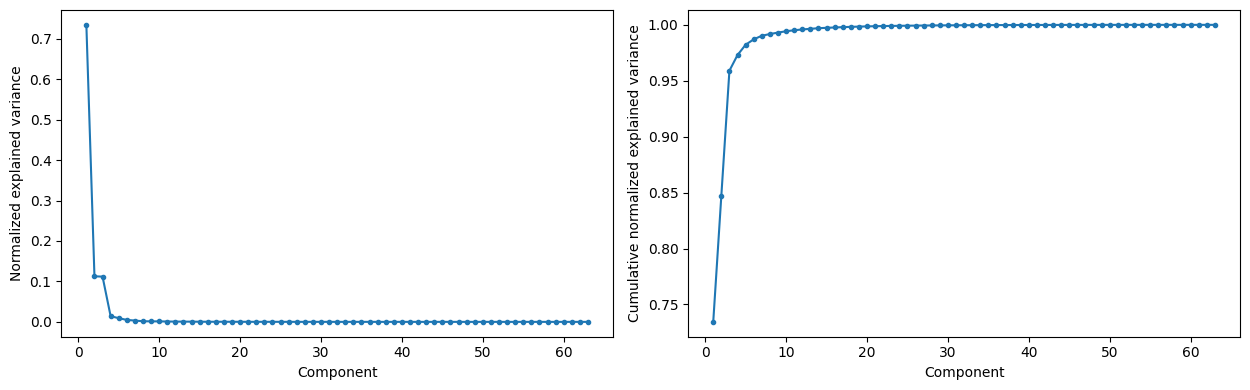

Loading fitted HMP model for accuracy condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3165: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Loading fitted HMP model for speed condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3165: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


In [20]:
cpus = 6

epoched_data_path = DATA_PATH / "sat2/data_250hz_part2.nc"
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

# 5 comps
stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    fits_to_load=["250hz_accuracy_part2.nc", "250hz_speed_part2.nc"]
)
# Retraining model with smaller window
stage_finder.fit_model()

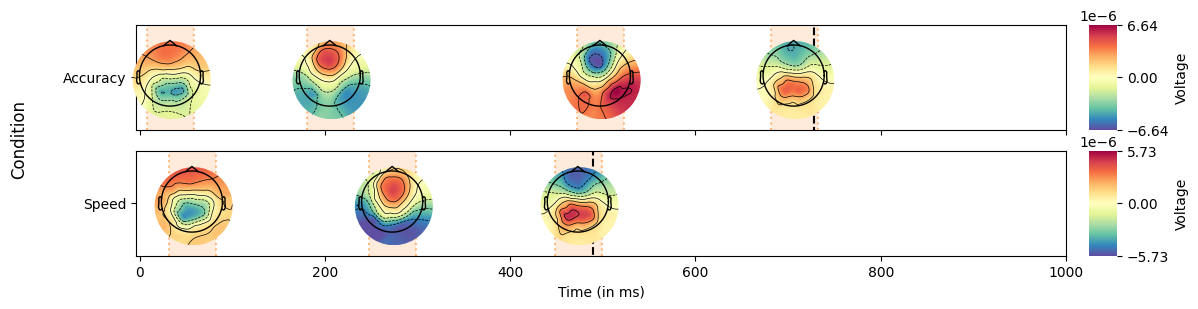

In [21]:
import matplotlib.pyplot as plt
fig, ax = stage_finder.visualize_model(positions, max_time=1000)

In [ ]:
output_path = DATA_PATH / "sat2/stage_data_250hz_part2.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_bump_to_bump__)

In [7]:
output_path = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_model_probabilistic__, probabilistic=True)

Labeling dataset for accuracy condition
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9


In [8]:
stage_data.isel(participant=0, epochs=100, channels=0, labels=1).probabilities

<xarray.DataArray 'probabilities' (samples: 698)> Size: 3kB
array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.5642173e-02,
       6.4346679e-02, 8.5025936e-02, 9.7010292e-02, 1.0037789e-01,
       9.5597275e-02, 8.4555447e-02, 7.0501275e-02, 5.6383241e-02,
       4.4863816e-02, 3.6922637e-02, 3.1561814e-02, 2.7768319e-02,
       2.4929626e-02, 2.1985991e-02, 1.8752327e-02, 1.6049312e-02,
...
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)
Coordinates:
    epochs       int64 8B 100
    channels     <U3 12B 'Fp1'
  * samples      (samples) int64 6kB 0 1 2 3 4 5 6 ... 692 693 694 695 696 697
    participant  <U3 12B 'S2'
    event_name   <U21 84B 'low/accuracy/right/3'
    rt           float64 8B 0.29

In [ ]:

# stage_data = stage_finder.label_model(stage_finder.__label_samples_around_bump__, {"window": (2, 2), "get_negative_class": False})

In [8]:
stage_data.to_netcdf(output_path)